In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# funding_rounds 불러오기
funding_rounds=pd.read_csv('./Datset/crunchbase_1/funding_rounds.csv',index_col=0)

# 'raised_amount_usd' 칼럼에 대해서만 Na값 0으로 처리
funding_rounds['raised_amount_usd'] = funding_rounds['raised_amount_usd'].fillna(0)

# 전처리 결과물을 담을 df 생성
org = pd.DataFrame({'org_uuid': funding_rounds['org_uuid'].unique()})

# Debt Financing, Convertible Note를 통해 투자받은 기록만 확인
lst1=[]
for i in funding_rounds['name']:
    lst1.append('Debt Financing' in i)

lst2=[]
for i in funding_rounds['name']:
    lst2.append('Convertible Note' in i)

debt_firms = funding_rounds[lst1 or lst2]

# debt_firms에 대해서 org_uuids에 대해 groupby해서 summation 구하기.
org_financing =  debt_firms[['org_uuid','raised_amount_usd']].groupby('org_uuid').sum().rename(columns = {'raised_amount_usd':'financing'})

# financing 행 org에 병합
org = pd.merge(org, org_financing, how = 'left', on = 'org_uuid').set_index('org_uuid').fillna(0)

# aver_money
aver_money = funding_rounds.groupby('org_uuid').mean()['raised_amount_usd']

# aver_money행 org에 병합
org = pd.merge(org, aver_money, how = 'left', on = 'org_uuid').fillna(0).rename(columns = {"raised_amount_usd":'aver_money'})

total = funding_rounds.groupby('org_uuid').sum()['raised_amount_usd']
org = pd.merge(org, total, how = 'left', on = 'org_uuid').fillna(0)

# ipo, acquisition, success 여부
ipo_acquisitions = pd.read_csv('./Datset/by_success.csv',index_col=0).rename(columns = {"uuid":'org_uuid'}).set_index('org_uuid')
org = pd.merge(org,ipo_acquisitions, how='left',on='org_uuid')
org['success'] = org['is_acquisitions'] + org['is_ipos']
org['success'] = org['success'].astype(bool)
org = org[['financing','raised_amount_usd','aver_money','success']]

# organizations의 status 칼럼 추가가
organizations = pd.read_csv('./Datset/crunchbase_4/organizations.csv').rename(columns = {'uuid':'org_uuid'})
org = pd.merge(org, organizations[['org_uuid','status']], how = 'left', on = 'org_uuid')

In [5]:
# IPO나 인수합병에 성공한 회사에 대해서 각각 'valuation_price_usd', 'price_usd'의 크기를 기준으로 4개의 rank로 나눌 것임.
df4=pd.read_csv('./Dataset/crunchbase_1/acquisitions.csv')
df5=pd.read_csv('./Dataset/crunchbase_2/ipos.csv')

# 각각 price에 대해 sort
Acquired=df4[['acquiree_uuid','price_usd']]
Acquired.dropna(inplace=True)
Acquired['price_usd'] = Acquired['price_usd'].apply(lambda x: int(x))
Acquired.sort_values(by=['price_usd'], inplace=True)

IPO=df5[['org_uuid','valuation_price_usd']]
IPO.dropna(inplace=True)
IPO['valuation_price_usd'] = IPO['valuation_price_usd'].apply(lambda x: int(x))
IPO.sort_values(by=['valuation_price_usd'], inplace=True)

Acquired['Rank_Acq']=0
IPO['Rank_IPO']=0

# rank 부여여
n=0
for rank in range (1,5):
  for i in range(int(len(Acquired)/4)):
    Acquired['Rank_Acq'].iloc[n]=rank
    n+=1
  
Acquired['Rank_Acq'].iloc[-1]=4
Acquired['Rank_Acq'].iloc[-2]=4

n=0
for rank in range (1,5):
  for i in range(int(len(IPO)/4)):
    IPO['Rank_IPO'].iloc[n]=rank
    n+=1
IPO['Rank_IPO'].iloc[-1]=4

Acquired=Acquired.rename(columns={'acquiree_uuid':'org_uuid'})
Ranks=pd.merge(IPO,Acquired,how='outer',on='org_uuid')

ranks = Ranks[['org_uuid','Rank_IPO','Rank_Acq']]
org = pd.merge(org, ranks, how = 'left', on = 'org_uuid')

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
<ipython-input-5-cf23cb07fa05>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Acquired['price_usd'] = Acquired['price_usd'].apply(lambda x: int(x))
<ipython-input-5-cf23cb07fa05>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

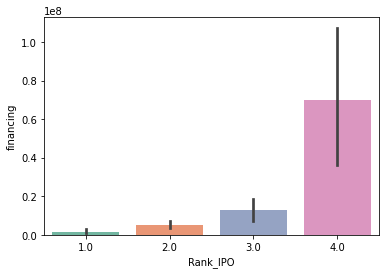

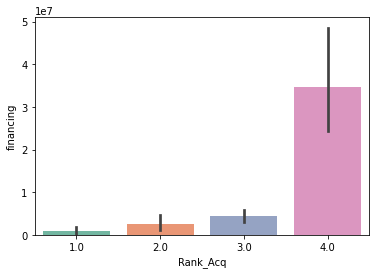

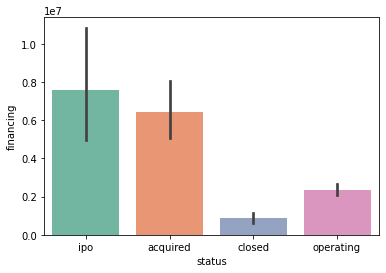

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette("Set2")

sns.barplot(data = org, x = 'Rank_IPO', y = 'financing', estimator = np.mean)
plt.show()

sns.barplot(data = org, x = 'Rank_Acq', y = 'financing', estimator = np.mean)
plt.show()

sns.barplot(data = org, x = 'status', y = 'financing', estimator = np.mean)
plt.show()